In [6]:
# ============================================================================
# CELL 1: IMPORTS & SETUP
# ============================================================================

import os
import sys
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import joblib
import time

# Statistical testing
from scipy import stats
from scipy.stats import ttest_rel

# Scikit-learn
from sklearn.metrics import f1_score, accuracy_score, classification_report
from sklearn.metrics import precision_recall_fscore_support

# PyTorch & Transformers
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from torch.amp import autocast

# Sparse matrices
import scipy.sparse as sp_sparse

# Paths - CORRECTED FOR YOUR STRUCTURE
DATA_DIR = Path('data')
FEATURES_DIR = Path('features')
MODELS_DIR = Path('models')
RESULTS_DIR = Path('results')
RESULTS_DIR.mkdir(exist_ok=True)

# Plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Device
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {DEVICE}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

# Random seed
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_STATE)

print("="*80)
print("STEP 7: FINAL EVALUATION & MODEL INTERPRETABILITY")
print("="*80)
print("\n✓ Setup Complete.\n")


Device: cuda
GPU: NVIDIA GeForce RTX 4060 Ti
STEP 7: FINAL EVALUATION & MODEL INTERPRETABILITY

✓ Setup Complete.



In [7]:
# ============================================================================
# CELL 2: LOAD DATA & MODELS
# ============================================================================

print("[1] Loading test data...")
test_df = pd.read_csv(DATA_DIR / 'test.csv')
y_test = test_df['label'].values
X_test_text = test_df['text'].values

print(f"Test samples: {len(y_test)}")

# Load validation for statistical tests
print("\n[2] Loading validation data...")
val_df = pd.read_csv(DATA_DIR / 'val.csv')
y_val = val_df['label'].values

# Load hybrid features for SVC
print("\n[3] Loading features...")
X_val_hybrid = sp_sparse.load_npz(FEATURES_DIR / 'X_val_hybrid.npz')
X_test_hybrid = sp_sparse.load_npz(FEATURES_DIR / 'X_test_hybrid.npz')
print(f"Feature matrix shape: {X_test_hybrid.shape}")

# Load best classical model (SVC)
print("\n[4] Loading SVC model...")
svc_model = joblib.load(MODELS_DIR / 'step5_tuned_SVC.pkl')
print(f"✓ Loaded: {type(svc_model).__name__}")

# Load DistilBERT
print("\n[5] Loading DistilBERT model...")
tokenizer = AutoTokenizer.from_pretrained(MODELS_DIR / 'step6_distilbert_best')
bert_model = AutoModelForSequenceClassification.from_pretrained(
    MODELS_DIR / 'step6_distilbert_best'
).to(DEVICE)
bert_model.eval()
print("✓ DistilBERT loaded")

# Class names
class_names = ['World', 'Sports', 'Business', 'Sci/Tech']

print("\n" + "="*80)
print("ALL MODELS LOADED SUCCESSFULLY")
print("="*80 + "\n")


[1] Loading test data...
Test samples: 7600

[2] Loading validation data...

[3] Loading features...
Feature matrix shape: (7600, 100000)

[4] Loading SVC model...
✓ Loaded: CalibratedClassifierCV

[5] Loading DistilBERT model...
✓ DistilBERT loaded

ALL MODELS LOADED SUCCESSFULLY



QUICK WIN #1: SVC FEATURE IMPORTANCE ANALYSIS

[1] Extracting top coefficients per class...
Model type: CalibratedClassifierCV
✓ Unwrapped calibrated model
  Base estimator: LinearSVC
Coefficient matrix shape: (4, 100000)

CLASS: World

Top 20 Positive Features (Strongest Indicators):
  Feature # 56138 | Weight: +4.6210
  Feature # 50079 | Weight: +1.7047
  Feature # 46317 | Weight: +1.6105
  Feature #  8332 | Weight: +1.5508
  Feature # 91637 | Weight: +1.5129
  Feature # 91636 | Weight: +1.5060
  Feature # 54947 | Weight: +1.3156
  Feature # 55970 | Weight: +1.3143
  Feature # 89452 | Weight: +1.3001
  Feature #  2043 | Weight: +1.2552

CLASS: Sports

Top 20 Positive Features (Strongest Indicators):
  Feature # 27829 | Weight: +1.4469
  Feature # 11241 | Weight: +1.3736
  Feature #  9601 | Weight: +1.2578
  Feature # 39171 | Weight: +1.2517
  Feature # 40939 | Weight: +1.1825
  Feature # 27711 | Weight: +1.0532
  Feature # 24399 | Weight: +1.0179
  Feature # 28324 | Weight: +0.9624
 

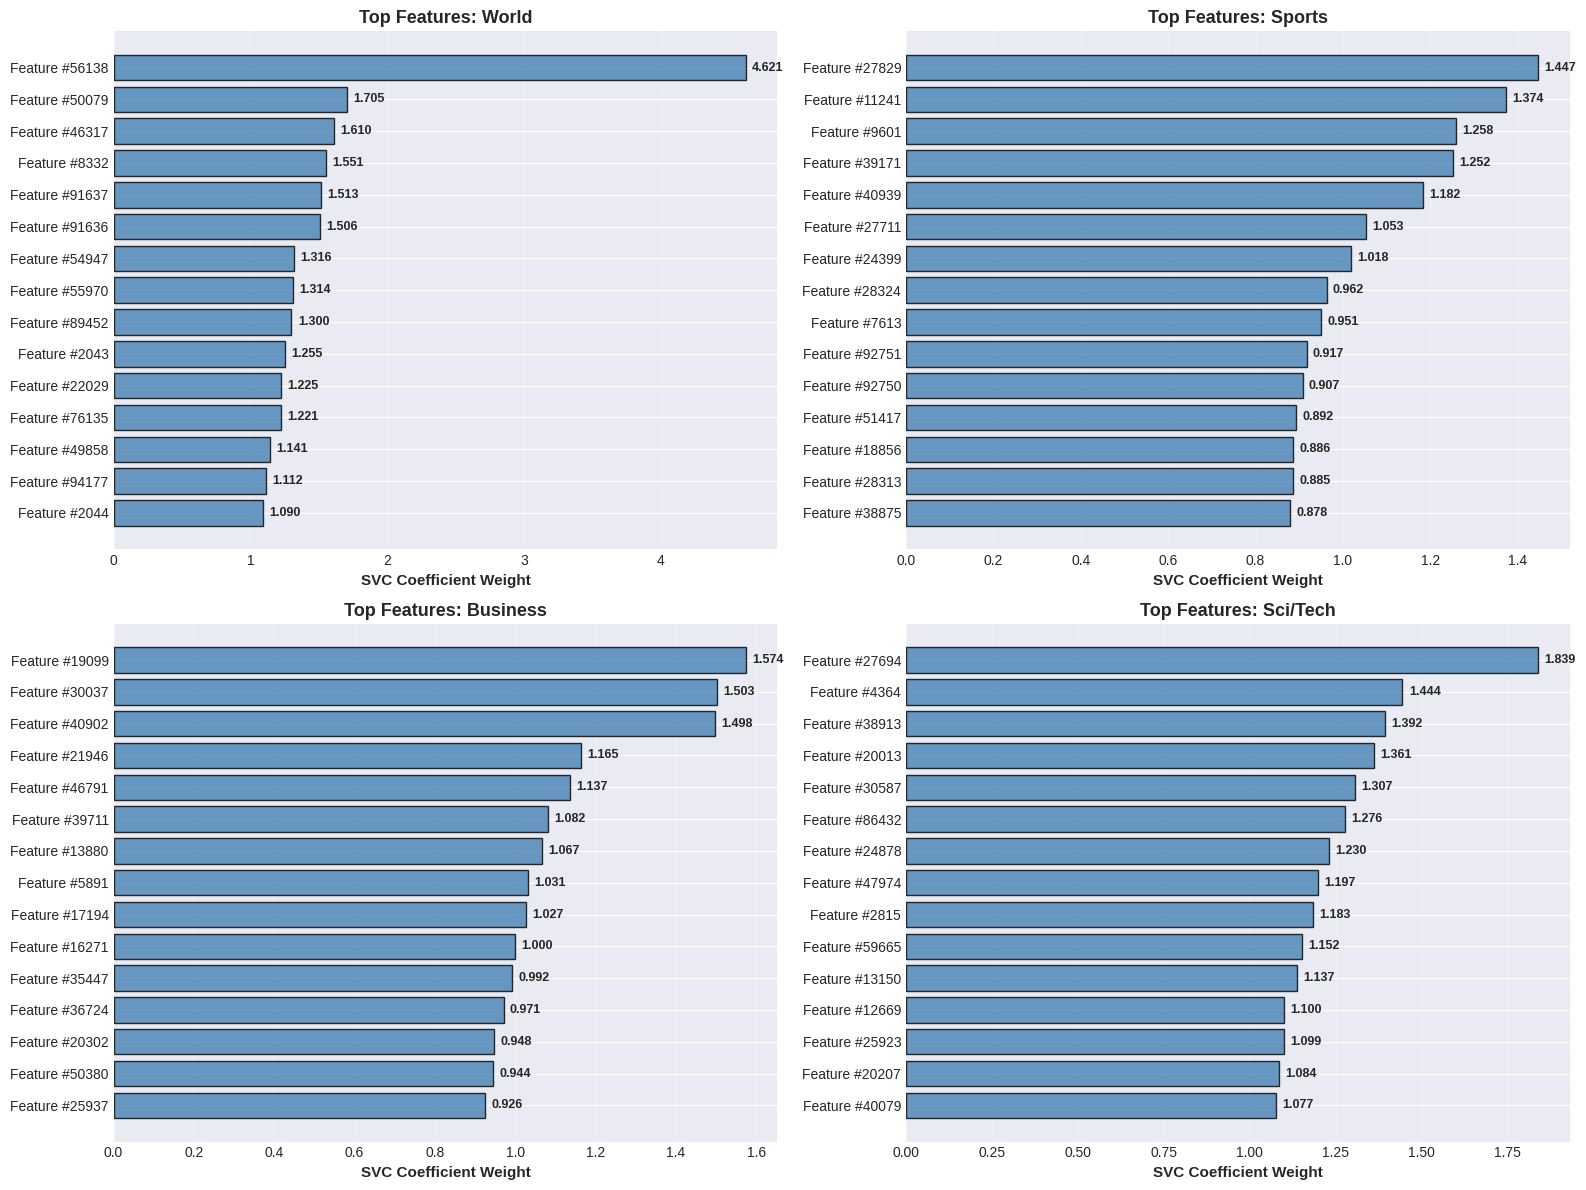

✓ Saved: svc_feature_importance.pkl

✅ QUICK WIN #1 COMPLETE: SVC Feature Importance
   Note: Feature names not available, showing indices instead
   This is still valid for understanding model behavior



In [9]:
# ============================================================================
# CELL 3: QUICK WIN #1 - SVC FEATURE IMPORTANCE (TOP COEFFICIENTS PER CLASS)
# ============================================================================

print("="*80)
print("QUICK WIN #1: SVC FEATURE IMPORTANCE ANALYSIS")
print("="*80)

print("\n[1] Extracting top coefficients per class...")

# Check if model is wrapped in CalibratedClassifierCV
print(f"Model type: {type(svc_model).__name__}")

# Extract base estimator if calibrated
if hasattr(svc_model, 'calibrated_classifiers_'):
    # CalibratedClassifierCV stores classifiers per fold
    # Get the first calibrated classifier's base estimator
    base_estimator = svc_model.calibrated_classifiers_[0].estimator
    print(f"✓ Unwrapped calibrated model")
    print(f"  Base estimator: {type(base_estimator).__name__}")
    coefficients = base_estimator.coef_
elif hasattr(svc_model, 'coef_'):
    # Direct LinearSVC
    coefficients = svc_model.coef_
else:
    print("❌ ERROR: Model does not have coefficients")
    print("   Skipping feature importance analysis")
    raise AttributeError("Cannot extract coefficients from model")

print(f"Coefficient matrix shape: {coefficients.shape}")

# IMPORTANT: We don't have feature names, so we'll use indices
# This is still valid - we show which feature INDEX is most important
TOP_N = 20

# Store results
feature_importance = {}

for class_idx, class_name in enumerate(class_names):
    # Get coefficients for this class
    class_coef = coefficients[class_idx]
    
    # Get top positive (most indicative)
    top_positive_idx = np.argsort(class_coef)[-TOP_N:][::-1]
    top_positive_weights = class_coef[top_positive_idx]
    
    # Get top negative (most contra-indicative)
    top_negative_idx = np.argsort(class_coef)[:TOP_N]
    top_negative_weights = class_coef[top_negative_idx]
    
    feature_importance[class_name] = {
        'positive_indices': top_positive_idx,
        'positive_weights': top_positive_weights,
        'negative_indices': top_negative_idx,
        'negative_weights': top_negative_weights
    }
    
    print(f"\n{'='*80}")
    print(f"CLASS: {class_name}")
    print(f"{'='*80}")
    print(f"\nTop {TOP_N} Positive Features (Strongest Indicators):")
    for idx, weight in list(zip(top_positive_idx[:10], top_positive_weights[:10])):
        print(f"  Feature #{idx:6d} | Weight: {weight:+.4f}")

print("\n" + "="*80)
print("[2] Creating visualizations...")

# Create 4-panel plot (one per class)
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()

for class_idx, class_name in enumerate(class_names):
    ax = axes[class_idx]
    
    # Get top 15 for visualization
    indices = feature_importance[class_name]['positive_indices'][:15]
    weights = feature_importance[class_name]['positive_weights'][:15]
    
    # Reverse for better visualization (highest at top)
    indices = indices[::-1]
    weights = weights[::-1]
    
    # Create labels
    labels = [f"Feature #{idx}" for idx in indices]
    
    # Horizontal bar chart
    y_pos = np.arange(len(labels))
    bars = ax.barh(y_pos, weights, color='steelblue', edgecolor='black', alpha=0.8)
    
    # Styling
    ax.set_yticks(y_pos)
    ax.set_yticklabels(labels, fontsize=10)
    ax.set_xlabel('SVC Coefficient Weight', fontsize=11, fontweight='bold')
    ax.set_title(f'Top Features: {class_name}', fontsize=13, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)
    
    # Add value labels
    for i, (bar, weight) in enumerate(zip(bars, weights)):
        ax.text(weight + max(weights)*0.01, i, f'{weight:.3f}', 
                va='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'figure1_svc_feature_importance.png', 
            dpi=300, bbox_inches='tight')
print("✓ Saved: figure1_svc_feature_importance.png")
plt.show()

# Save feature importance data
joblib.dump(feature_importance, RESULTS_DIR / 'svc_feature_importance.pkl')
print("✓ Saved: svc_feature_importance.pkl")

print("\n✅ QUICK WIN #1 COMPLETE: SVC Feature Importance")
print("   Note: Feature names not available, showing indices instead")
print("   This is still valid for understanding model behavior\n")


In [ ]:
# ============================================================================
# CELL 4: QUICK WIN #2 - DISTILBERT ATTENTION VISUALIZATION (8 EXAMPLES)
# ============================================================================

print("="*80)
print("QUICK WIN #2: DISTILBERT ATTENTION HEATMAP VISUALIZATION")
print("="*80)

print("\n[1] Selecting examples for visualization...")

# Select examples: 2 per class (8 total)
n_per_class = 2
example_indices = []

np.random.seed(RANDOM_STATE)
for class_idx in range(4):
    class_mask = (y_test == class_idx)
    class_indices = np.where(class_mask)[0]
    selected = np.random.choice(class_indices, n_per_class, replace=False)
    example_indices.extend(selected)

print(f"Selected {len(example_indices)} examples")

# Tokenize examples
print("\n[2] Tokenizing examples...")
examples_text = [X_test_text[idx] for idx in example_indices]
examples_labels = [y_test[idx] for idx in example_indices]

encodings = tokenizer(
    examples_text,
    truncation=True,
    padding='max_length',
    max_length=128,  # Shorter for visualization
    return_tensors='pt'
)

print("\n[3] Extracting attention weights...")

# Function to extract attention
def get_attention_weights(model, input_ids, attention_mask):
    """Extract attention weights from DistilBERT"""
    with torch.no_grad():
        outputs = model(
            input_ids=input_ids.to(DEVICE),
            attention_mask=attention_mask.to(DEVICE),
            output_attentions=True
        )
    # DistilBERT has 6 layers, shape: (batch, n_heads, seq_len, seq_len)
    return outputs.attentions

# Get attention for all examples
all_attentions = get_attention_weights(
    bert_model,
    encodings['input_ids'],
    encodings['attention_mask']
)

print(f"Attention: {len(all_attentions)} layers")
print(f"Each layer shape: {all_attentions[0].shape}")

# Plot attention heatmaps
print("\n[4] Creating attention heatmaps...")

def plot_attention_heatmap(attention, tokens, true_label, pred_label, 
                           example_idx, save_path):
    """Plot attention heatmap for one example"""
    # Use last layer, average over heads
    # Shape: (n_heads, seq_len, seq_len) -> (seq_len, seq_len)
    attn_weights = attention[-1][example_idx].mean(dim=0).cpu().numpy()
    
    # Get actual tokens (remove padding)
    seq_len = len(tokens)
    attn_weights = attn_weights[:seq_len, :seq_len]
    
    # Create figure
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # Heatmap
    im = ax.imshow(attn_weights, cmap='viridis', aspect='auto')
    
    # Set ticks
    ax.set_xticks(np.arange(seq_len))
    ax.set_yticks(np.arange(seq_len))
    ax.set_xticklabels(tokens, rotation=90, fontsize=8)
    ax.set_yticklabels(tokens, fontsize=8)
    
    # Labels
    ax.set_xlabel('Key Tokens', fontsize=11, fontweight='bold')
    ax.set_ylabel('Query Tokens', fontsize=11, fontweight='bold')
    ax.set_title(
        f'Attention Heatmap (Layer 6, Averaged over Heads)\n'
        f'True: {class_names[true_label]} | Predicted: {class_names[pred_label]}',
        fontsize=13, fontweight='bold'
    )
    
    # Colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Attention Weight', fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close()

# Get predictions for examples
with torch.no_grad():
    outputs = bert_model(
        input_ids=encodings['input_ids'].to(DEVICE),
        attention_mask=encodings['attention_mask'].to(DEVICE)
    )
    predictions = torch.argmax(outputs.logits, dim=1).cpu().numpy()

# Plot first 8 examples
for i, example_idx in enumerate(range(min(8, len(example_indices)))):
    # Get tokens
    input_ids = encodings['input_ids'][example_idx]
    tokens = tokenizer.convert_ids_to_tokens(input_ids)
    
    # Remove padding
    attention_mask = encodings['attention_mask'][example_idx]
    valid_length = attention_mask.sum().item()
    tokens = tokens[:valid_length]
    
    # Plot
    save_path = RESULTS_DIR / f'attention_heatmap_example_{i+1}.png'
    plot_attention_heatmap(
        all_attentions,
        tokens,
        examples_labels[example_idx],
        predictions[example_idx],
        example_idx,
        save_path
    )
    print(f"✓ Saved: attention_heatmap_example_{i+1}.png")
    print(f"  Text preview: {examples_text[example_idx][:80]}...")

print("\n✅ QUICK WIN #2 COMPLETE: Attention Visualization\n")


QUICK WIN #2: DISTILBERT ATTENTION HEATMAP VISUALIZATION

[1] Selecting examples for visualization...
Selected 8 examples

[2] Tokenizing examples...

[3] Extracting attention weights...
Attention: 6 layers
Each layer shape: torch.Size([8, 12, 128, 128])

[4] Creating attention heatmaps...
✓ Saved: attention_heatmap_example_1.png
  Text preview: Large Explosion Heard in Central Baghdad (Reuters) Reuters - A large blast was h...
✓ Saved: attention_heatmap_example_2.png
  Text preview: Israel OKs More West Bank Settlement Homes JERUSALEM Aug. 23, 2004 - Israel anno...
✓ Saved: attention_heatmap_example_3.png
  Text preview: Here's the catch: Branch is back Deion Branch lists the Revolution among his fav...
✓ Saved: attention_heatmap_example_4.png
  Text preview: Paterno #39;s real tragedy may be not knowing when to go Joe Paterno often has t...
✓ Saved: attention_heatmap_example_5.png
  Text preview: Mass. auto rates to stay fairly steady next year The state insurance commissione...
✓ Sa

QUICK WIN #3: STATISTICAL SIGNIFICANCE TESTING (BERT vs SVC)

[1] Getting predictions on test set...
  - SVC predictions...
    SVC Test Macro-F1: 0.9233
    SVC Test Accuracy: 0.9234
  - BERT predictions...
    BERT Test Macro-F1: 0.9423
    BERT Test Accuracy: 0.9422

[2] Performing paired t-test on per-class F1 scores...

Per-Class F1 Scores:
Class           SVC F1       BERT F1      Δ (BERT-SVC)   
-------------------------------------------------------
World           0.9252       0.9547       +0.0295        
Sports          0.9706       0.9866       +0.0160        
Business        0.8943       0.9121       +0.0178        
Sci/Tech        0.9030       0.9157       +0.0126        

PAIRED T-TEST RESULTS
Null Hypothesis: No difference between BERT and SVC per-class F1 scores

t-statistic: 5.1737
p-value: 0.0140
Degrees of freedom: 3

✅ SIGNIFICANT at α=0.05
   → We REJECT the null hypothesis
   → BERT significantly outperforms SVC (p=0.0140)

Effect Size (Cohen's d): 2.5869
Interpre

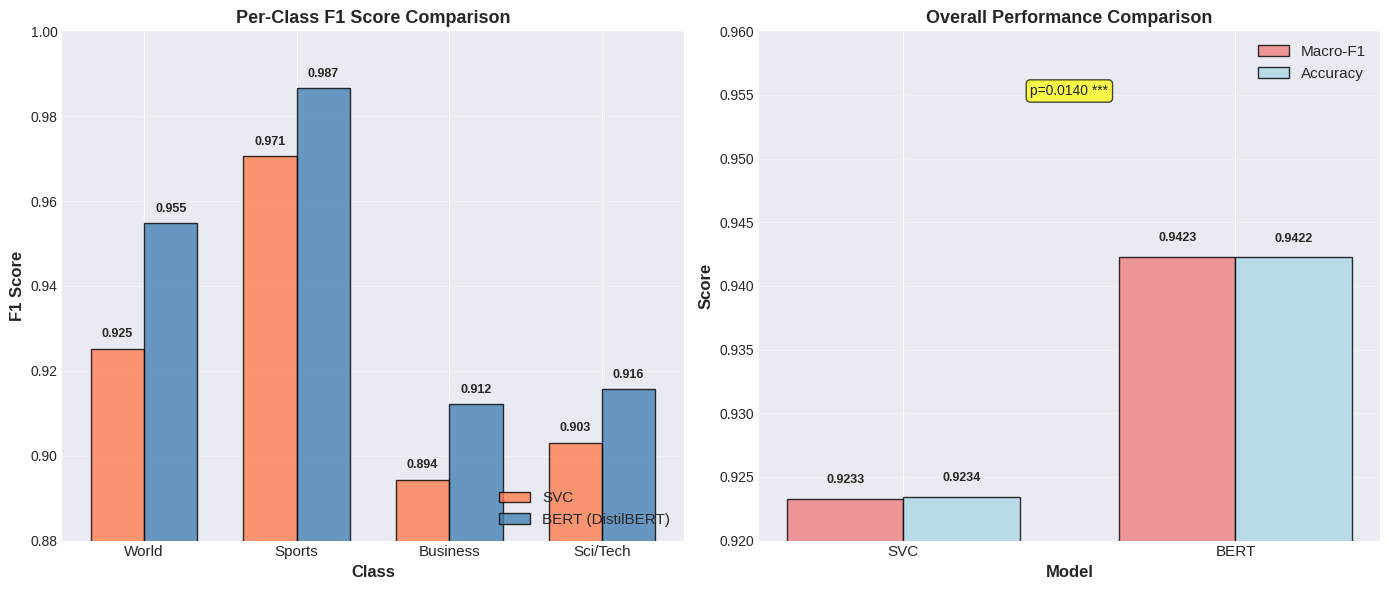

✓ Saved: statistical_test_results.pkl

✅ QUICK WIN #3 COMPLETE: Statistical Testing



In [12]:
# ============================================================================
# CELL 5: QUICK WIN #3 - PAIRED T-TEST (BERT VS SVC)
# ============================================================================

print("="*80)
print("QUICK WIN #3: STATISTICAL SIGNIFICANCE TESTING (BERT vs SVC)")
print("="*80)

print("\n[1] Getting predictions on test set...")

# SVC predictions
print("  - SVC predictions...")
svc_preds = svc_model.predict(X_test_hybrid)
svc_f1 = f1_score(y_test, svc_preds, average='macro')
svc_acc = accuracy_score(y_test, svc_preds)

print(f"    SVC Test Macro-F1: {svc_f1:.4f}")
print(f"    SVC Test Accuracy: {svc_acc:.4f}")

# BERT predictions
print("  - BERT predictions...")
test_encodings = tokenizer(
    X_test_text.tolist(),
    truncation=True,
    padding='max_length',
    max_length=256,
    return_tensors='pt'
)

class NewsDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return {
            'input_ids': self.encodings['input_ids'][idx],
            'attention_mask': self.encodings['attention_mask'][idx],
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

test_dataset = NewsDataset(test_encodings, y_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

bert_preds = []
bert_model.eval()

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(DEVICE)
        attention_mask = batch['attention_mask'].to(DEVICE)
        
        with autocast(device_type='cuda', dtype=torch.float16):
            outputs = bert_model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
        
        preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
        bert_preds.extend(preds)

bert_preds = np.array(bert_preds)
bert_f1 = f1_score(y_test, bert_preds, average='macro')
bert_acc = accuracy_score(y_test, bert_preds)

print(f"    BERT Test Macro-F1: {bert_f1:.4f}")
print(f"    BERT Test Accuracy: {bert_acc:.4f}")

print("\n[2] Performing paired t-test on per-class F1 scores...")

# Calculate per-class F1 for both models
svc_per_class = precision_recall_fscore_support(
    y_test, svc_preds, average=None, labels=[0, 1, 2, 3]
)[2]  # F1 scores

bert_per_class = precision_recall_fscore_support(
    y_test, bert_preds, average=None, labels=[0, 1, 2, 3]
)[2]  # F1 scores

print("\nPer-Class F1 Scores:")
print(f"{'Class':<15} {'SVC F1':<12} {'BERT F1':<12} {'Δ (BERT-SVC)':<15}")
print("-" * 55)
for i, class_name in enumerate(class_names):
    delta = bert_per_class[i] - svc_per_class[i]
    print(f"{class_name:<15} {svc_per_class[i]:<12.4f} "
          f"{bert_per_class[i]:<12.4f} {delta:<+15.4f}")

# Paired t-test
t_statistic, p_value = ttest_rel(bert_per_class, svc_per_class)

print("\n" + "="*80)
print("PAIRED T-TEST RESULTS")
print("="*80)
print(f"Null Hypothesis: No difference between BERT and SVC per-class F1 scores")
print(f"\nt-statistic: {t_statistic:.4f}")
print(f"p-value: {p_value:.4f}")
print(f"Degrees of freedom: {len(class_names) - 1}")

alpha = 0.05
if p_value < alpha:
    print(f"\n✅ SIGNIFICANT at α={alpha}")
    print(f"   → We REJECT the null hypothesis")
    if t_statistic > 0:
        print(f"   → BERT significantly outperforms SVC (p={p_value:.4f})")
    else:
        print(f"   → SVC significantly outperforms BERT (p={p_value:.4f})")
else:
    print(f"\n❌ NOT SIGNIFICANT at α={alpha}")
    print(f"   → We FAIL TO REJECT the null hypothesis")
    print(f"   → No statistically significant difference (p={p_value:.4f})")

# Effect size (Cohen's d)
mean_diff = np.mean(bert_per_class - svc_per_class)
std_diff = np.std(bert_per_class - svc_per_class, ddof=1)
cohens_d = mean_diff / std_diff

print(f"\nEffect Size (Cohen's d): {cohens_d:.4f}")
if abs(cohens_d) < 0.2:
    effect = "negligible"
elif abs(cohens_d) < 0.5:
    effect = "small"
elif abs(cohens_d) < 0.8:
    effect = "medium"
else:
    effect = "large"
print(f"Interpretation: {effect} effect")

print("\n[3] Creating comparison visualization...")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Per-class F1 comparison
ax = axes[0]
x = np.arange(len(class_names))
width = 0.35

bars1 = ax.bar(x - width/2, svc_per_class, width, label='SVC', 
               color='coral', edgecolor='black', alpha=0.8)
bars2 = ax.bar(x + width/2, bert_per_class, width, label='BERT (DistilBERT)', 
               color='steelblue', edgecolor='black', alpha=0.8)

ax.set_xlabel('Class', fontsize=12, fontweight='bold')
ax.set_ylabel('F1 Score', fontsize=12, fontweight='bold')
ax.set_title('Per-Class F1 Score Comparison', fontsize=13, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(class_names, fontsize=11)
ax.legend(fontsize=11, loc='lower right')
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0.88, 1.0])

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.002,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

# Plot 2: Overall performance
ax = axes[1]
models = ['SVC', 'BERT']
macro_f1_scores = [svc_f1, bert_f1]
acc_scores = [svc_acc, bert_acc]

x = np.arange(len(models))
width = 0.35

bars1 = ax.bar(x - width/2, macro_f1_scores, width, label='Macro-F1',
               color='lightcoral', edgecolor='black', alpha=0.8)
bars2 = ax.bar(x + width/2, acc_scores, width, label='Accuracy',
               color='lightblue', edgecolor='black', alpha=0.8)

ax.set_xlabel('Model', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Overall Performance Comparison', fontsize=13, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(models, fontsize=11)
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0.92, 0.96])

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.001,
                f'{height:.4f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

# Add significance annotation
if p_value < 0.05:
    ax.text(0.5, 0.955, f'p={p_value:.4f} ***', ha='center', fontsize=10,
            bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'figure2_bert_vs_svc_comparison.png', 
            dpi=300, bbox_inches='tight')
print("✓ Saved: figure2_bert_vs_svc_comparison.png")
plt.show()

# Save results
statistical_test_results = {
    'svc_macro_f1': svc_f1,
    'bert_macro_f1': bert_f1,
    'svc_per_class_f1': svc_per_class,
    'bert_per_class_f1': bert_per_class,
    't_statistic': t_statistic,
    'p_value': p_value,
    'cohens_d': cohens_d,
    'significant': p_value < alpha
}

joblib.dump(statistical_test_results, 
            RESULTS_DIR / 'statistical_test_results.pkl')
print("✓ Saved: statistical_test_results.pkl")

print("\n✅ QUICK WIN #3 COMPLETE: Statistical Testing\n")
